In [1]:
# Initialize 
import therpy as tp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets
import warnings
from tqdm import tqdm_notebook as tqdm
import os

warnings.filterwarnings("ignore")
%matplotlib inline
cst = tp.cst()
kHz = 1e3*cst.h
twopi = 2*np.pi
pi = np.pi

The servers are not connected!
Using the local database copy. Could be outdated!


In [2]:
# Useful snippets 
default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode']

def compute_moment(nz, zlim=550, trap_f=default_settings['trap_f']):
    mult = 4 * 1/2 * cst.mass * (twopi*trap_f)**2
    using = (nz.x >= -zlim*1e-6) & (nz.x <= zlim*1e-6)
    nz = tp.Curve(nz.x[using], nz.y[using])
    return mult * np.trapz(nz.y*nz.x**2, nz.x) / np.trapz(nz.y, nz.x) / kHz


In [3]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.35):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.35, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N

# Special Functions
def hybrid_total_atoms(kT, mu, trapf=23.35, cross_section=np.pi*(58e-6)**2):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    n_0 = UFG.density(kT, mu)
    z_max = 0
    while True:
        z_max += 50e-6
        if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
    z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
    n = UFG.density(kT, mu - u_* z**2)
    N = np.trapz(n, z) * cross_section
    return N

# Dataset Collections

In [ ]:
# DS4 : 11-15/16 
# DS2 : 7-14

In [ ]:
# DS4 : 6-9

06-09-2017_20_39_13_TopA
06-09-2017_20_39_13_TopB
06-09-2017_20_37_19_TopA
06-09-2017_20_37_19_TopB
06-09-2017_20_36_21_TopA
06-09-2017_20_36_21_TopB
06-09-2017_20_35_24_TopA
06-09-2017_20_35_24_TopB
06-09-2017_20_33_59_TopA
06-09-2017_20_33_59_TopB
06-09-2017_20_33_02_TopA
06-09-2017_20_33_02_TopB
06-09-2017_20_32_05_TopA
06-09-2017_20_32_05_TopB
06-09-2017_20_31_08_TopA
06-09-2017_20_31_08_TopB
06-09-2017_20_30_10_TopA
06-09-2017_20_30_10_TopB
06-09-2017_20_29_13_TopA
06-09-2017_20_29_13_TopB
06-09-2017_20_28_16_TopA
06-09-2017_20_28_16_TopB
06-09-2017_20_27_18_TopA
06-09-2017_20_27_18_TopB
06-09-2017_20_26_21_TopA
06-09-2017_20_26_21_TopB
06-09-2017_20_25_23_TopA
06-09-2017_20_25_23_TopB
06-09-2017_20_24_26_TopA
06-09-2017_20_24_26_TopB
06-09-2017_20_23_28_TopA
06-09-2017_20_23_28_TopB
06-09-2017_20_22_31_TopA
06-09-2017_20_22_31_TopB
06-09-2017_20_21_34_TopA
06-09-2017_20_21_34_TopB
06-09-2017_20_20_37_TopA
06-09-2017_20_20_37_TopB
06-09-2017_20_19_39_TopA
06-09-2017_20_19_39_TopB
06-09-2017_20_18_42_TopA
06-09-2017_20_18_42_TopB
06-09-2017_20_17_44_TopA
06-09-2017_20_17_44_TopB
06-09-2017_20_16_22_TopA
06-09-2017_20_16_22_TopB
06-09-2017_20_14_28_TopA
06-09-2017_20_14_28_TopB
06-09-2017_20_13_30_TopA
06-09-2017_20_13_30_TopB
06-09-2017_20_12_33_TopA
06-09-2017_20_12_33_TopB
06-09-2017_20_11_35_TopA
06-09-2017_20_11_35_TopB
06-09-2017_20_10_38_TopA
06-09-2017_20_10_38_TopB

# Hybrid Energy

Total energy per particle in the Hybrid potential
$$\frac{E}{N} = 2 m \omega^2 \left< z^2 \right> = 4 \left< U \right>$$

Reduced Energy 
$$ \frac{E}{E_0} = \frac{5}{3} \frac{E}{N E_F}$$

Here $  \left< U \right> $ is the normalized averages, normalized by the total atom numbers. 

We will employ two ways to extract the energy. 
* Equation of State Fits
* Second Moment

In [4]:
df_hyb_energy_all = pd.DataFrame()

In [5]:
# Relevant Parameters 
x_var_name = ['BoxShakeFreq', 'BoxShakeAmp', 'ShakingCycles','HeatCycles']
x_var_label = [r'$\nu$ (Hz)', 'Amplitude (V)', 'Cycles (#)','Heat Cycles (#)']
usei = 3
x_var_name, x_var_label = x_var_name[usei], x_var_label[usei]
image_use = 'A'

In [6]:
# Import from Clipboard 
df_hyb_energy_all = tp.images_from_clipboard(df=df_hyb_energy_all,
                                         x=x_var_name, 
                                         params=import_params,
                                         image_func=tp.Hybrid_Image,
                                         download=image_use,
                                         display=True)

HBox(children=(IntProgress(value=0, max=56), HTML(value='')))


Total Number of Shots 28, Images 28


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,HeatTime,ShakeWait,HeatCycles,ShakingCycles,BoxShakeFreq,BoxShakeAmp,BoxShakeTime,SeqMode,x
name,,,,,,,,,,,,,,,,,,,
06-09-2017_20_10_38_TopA,0,Image object,True,False,False,True,1500.0,0.5,1500.0,0.5,0.0,0.0,0.0,0.0,120.0,0.3,0.0,None,0.0
06-09-2017_20_11_35_TopA,0.966667,Image object,True,False,False,True,1500.0,0.5,1500.0,0.5,120.0,0.0,120.0,0.0,120.0,0.3,0.0,None,120.0
06-09-2017_20_12_33_TopA,1.91667,Image object,True,False,False,True,1500.0,0.5,1500.0,0.5,60.0,0.0,60.0,0.0,120.0,0.3,0.0,None,60.0


In [7]:
# Start Saving Folder 
savefig = ipywidgets.Checkbox(value=False, description='Save Figs')
display(savefig)
folder_name = df_hyb_energy_all.iloc[0].name[0:17] + 'Hybrid_Energy'
prefix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
prefix_samples = os.path.join(folder_name, 'Samples','')
os.makedirs(os.path.join(folder_name, 'Samples'), exist_ok=True)
prefix

Checkbox(value=False, description='Save Figs')

'06-09-2017_20_10_Hybrid_Energy/'

In [8]:
# Define 
settings = {**default_settings, 
            **dict(center_x = 1140, center_y = 1320, 
                   fudge=1.75, width=800, height=1500, 
                   subsample=3,
                   radial_selection=0.75,
                   Tfit_lim=0.1)}

In [9]:
# Verify Settings 

# Apply to all Images 
for n,r in df_hyb_energy_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_hyb_energy_all.shape[0])):
    r = df_hyb_energy_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    plt.show()

if df_hyb_energy_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_hyb_energy_all.shape[0]-1))

interactive(children=(IntSlider(value=25, description='test', max=27), Output()), _dom_classes=('widget-interact',))

HBox(children=(IntProgress(value=0, max=28), HTML(value='')))


Total Images 28 ==> Good 21, Bad 7


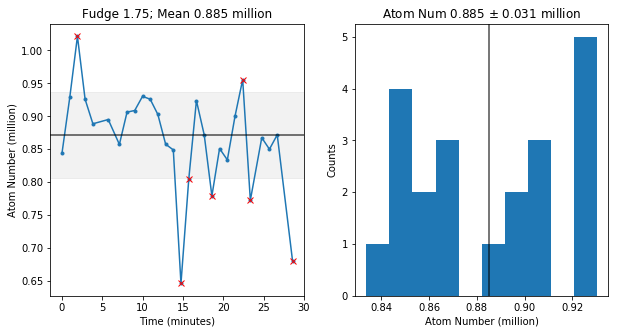

In [10]:
# Atom Number Filter 
df_hyb_energy_all['total_atoms'] = [im.total_atoms for im in tqdm(df_hyb_energy_all.image)]
ax = tp.atom_num_filter(df=df_hyb_energy_all, keep=0.075, offset=0.0, display=True, plot=True)
# ax[0].set(ylim=[0.3,None])
if savefig.value: plt.savefig(prefix + 'AtomNumbersScatter.pdf')
df_hyb_energy = df_hyb_energy_all[df_hyb_energy_all.use]

In [11]:
# Fit kT and mu0 vs fit lims 
cutoffs = np.linspace(0.03, 0.3, 6)
zlims = np.arange(200, 500, 10)
guess = dict(kT_kHz = settings['Tfit_guess_kT'],
             mu0_kHz = settings['Tfit_guess_mu0'],)
fixed = dict(trap_f=df_hyb_energy.iloc[0].image.trap_f, z0=0, fudge=1, offset=0, gradient=0)

def sample_EoS_fitrange(test=np.random.randint(0, df_hyb_energy.shape[0])): 
    # Extract needed variables for easy access 
    r = df_hyb_energy.iloc[test]
    img = r.image
    # Fit thermodynamic function n(z) 
    cf = tp.curve_fit(tp.density_unitary_hybrid, guess, 
                 *img.nz.trim(ylim=[-np.inf, settings['Tfit_lim'] * 1e18]).data, 
                 plot = False, fixed = fixed)
    # Fit thermodynamics to a range of density cutoffs 
    cfs = [tp.curve_fit(tp.density_unitary_hybrid, guess, 
                 *img.nz.trim(ylim=[-np.inf, c * 1e18]).data, 
                 plot = False, fixed = fixed) 
          for c in tqdm(cutoffs)]
    atoms_ratio = [c(img.nz.x).sum() / img.nz.y.sum() for c in cfs]
    # Compute moment vs zlim 
    z, n_data = img.nz.x, img.nz.y
    n_fit = cf(z)
    n_stitched = n_data.copy()
    n_stitched[n_fit <= settings['Tfit_lim'] * 1e18] = n_fit[n_fit <= settings['Tfit_lim'] * 1e18]
    moment_data = [compute_moment(tp.Curve(z, n_data), zl) for zl in zlims]
    moment_fit = [compute_moment(tp.Curve(z, n_fit), zl) for zl in zlims]
    moment_stitched = [compute_moment(tp.Curve(z, n_stitched), zl) for zl in zlims]
    
    # Plot Results 
    ax = plt.subplots(ncols=2, nrows=2, figsize=[7, 6])[1].flatten()
    ax[0].axhspan(2*cf.y.min()/1e18, settings['Tfit_lim'], color='k', alpha=0.1)
    ax[0].plot(*img.nz.plotdata, zorder=2)
    ax[0].plot(cf.xp*1e6, cf(cf.xp)/1e18, zorder=1)
    ax[0].fill_between(cf.xp*1e6, cf.yband(cf.xp)[0]/1e18, 
                       cf.yband(cf.xp)[1]/1e18, color='g', alpha=0.25, zorder=0)
    ax[1].errorbar(cutoffs, [c.fv['kT_kHz'] for c in cfs], [c.fe['kT_kHz'] for c in cfs])
    ax[1].errorbar(cutoffs, [c.fv['mu0_kHz'] for c in cfs], [c.fe['mu0_kHz'] for c in cfs])
    ax[2].plot(cutoffs, atoms_ratio, 'o')
    ax[3].plot(zlims, moment_data, '-')
    ax[3].plot(zlims, moment_fit, '-')
    ax[3].plot(zlims, moment_stitched, '-')
    ax[0].set(xlabel=r'z ($\mu m$)', ylabel=r'n ($\mu m^{-3}$)')
    ax[1].set(xlabel=r'n cutoff ($\mu m^{-3}$)', ylabel=r'kT, $\mu_0$ (kHz)')
    ax[2].set(xlabel=r'n cutoff ($\mu m^{-3}$)', ylabel=r'$N_{EoS}$ / $N_{Data}$')
    ax[3].set(xlabel=r'z cutoff ($\mu m$)', ylabel=r'E/N (kHz)')
    plt.tight_layout()

if df_hyb_energy.shape[0] == 1: sample_EoS_fitrange(0)
else: ipywidgets.interact(sample_EoS_fitrange, test=(0, df_hyb_energy.shape[0]-1),)

interactive(children=(IntSlider(value=8, description='test', max=20), Output()), _dom_classes=('widget-interact',))

In [12]:
# Fit thermodynamics n(z) to all data 
df_hyb_energy['nz_curvefit'] = [tp.curve_fit(tp.density_unitary_hybrid, guess, 
                           *img.nz.trim(ylim=[-np.inf, settings['Tfit_lim']*1e18]).data,
                            fixed = fixed)
                          for img in tqdm(df_hyb_energy.image)]
# Compute nz stitched 
df_hyb_energy['nz_data'] = None
df_hyb_energy['nz_fit'] = None
df_hyb_energy['nz_stitched'] = None
for n, r in df_hyb_energy.iterrows():
    z, n_data = r.image.nz.x, r.image.nz.y
    n_fit = r.nz_curvefit(z)
    use_fit = (n_fit <= settings['Tfit_lim'] * 1e18)
    n_stitched = n_data.copy()
    n_stitched[use_fit] = n_fit[use_fit]
    df_hyb_energy.loc[n, 'nz_data'] = tp.Curve(z, n_data, xscale=1e-6, yscale=1e18)
    df_hyb_energy.loc[n, 'nz_fit'] = tp.Curve(z, n_fit, xscale=1e-6, yscale=1e18)
    df_hyb_energy.loc[n, 'nz_stitched'] = tp.Curve(z, n_stitched, xscale=1e-6, yscale=1e18)

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

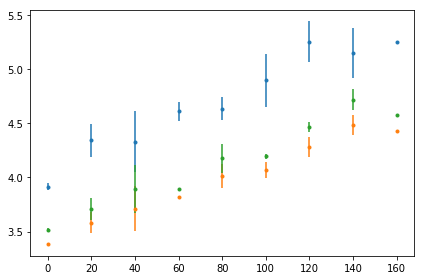

In [16]:
# Compute moment for the three nz's 
xi = df_hyb_energy.x.values
moment_data = np.array([compute_moment(nz) for nz in df_hyb_energy.nz_data])
moment_fit = np.array([compute_moment(nz) for nz in df_hyb_energy.nz_fit])
moment_stitched = np.array([compute_moment(nz) for nz in df_hyb_energy.nz_stitched])
moment_data = tp.bin_data(xi, moment_data)
moment_fit = tp.bin_data(xi, moment_fit)
moment_stitched = tp.bin_data(xi, moment_stitched)

plt.errorbar(*moment_data.std, fmt='.')
plt.errorbar(*moment_fit.std, fmt='.')
plt.errorbar(*moment_stitched.std, fmt='.')
plt.tight_layout()

# EoS and E/N Validity

In [122]:
kT_kHz = 2
mu0_kHz = 4

In [151]:
trap_f = default_settings['trap_f']
def EoS_EN_diff(kT_kHz, mu0_kHz):
    z = np.linspace(-400, 400, 500) * 1e-6
    n = tp.density_unitary_hybrid(z, kT_kHz=kT_kHz, mu0_kHz=mu0_kHz, trap_f=trap_f)
    u = 1/2 * cst.mass * (twopi*trap_f)**2 * z**2 
    EF = cst.n2EF(n)
    TTF = kT_kHz * kHz / EF
    c = tp.Curve(UFG.df['T/T_F'].values, UFG.df['E/E0'].values)
    EE0 = c(TTF)
    EN = (np.trapz(3/5 * EE0 * n * EF, z) + np.trapz(n * u, z)) / np.trapz(n, z) / kHz
    EN_moment = compute_moment(tp.Curve(z, n), trap_f=trap_f)
    diff = (EN_moment - EN) / EN * 100
    return (z, n, u, EF, TTF, EE0, EN, EN_moment, diff)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

[Text(0,0.5,'T/TF_0'), Text(0.5,0,'EF_0 (kHz)')]

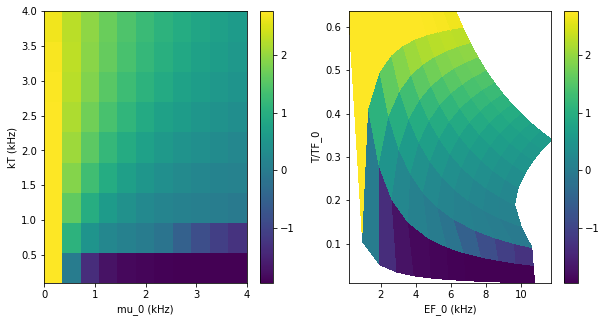

In [179]:
kT_kHz = np.linspace(0.1, 4, 10)
mu0_kHz = np.linspace(0, 4, 12)
perc_diff = np.zeros(shape = [len(kT_kHz), len(mu0_kHz)])
EF0 = np.zeros_like(perc_diff)
TTF0 = np.zeros_like(perc_diff)
for i,kT in enumerate(tqdm(kT_kHz)):
    for j,mu0 in enumerate(mu0_kHz):
        z, n, u, EF, TTF, EE0, EN, EN_moment, diff = EoS_EN_diff(kT, mu0)
        perc_diff[i,j] = diff
        EF0[i,j] = np.nanmax(EF) / kHz
        TTF0[i,j] = np.nanmin(TTF)
ax = plt.subplots(ncols=2, figsize=[10, 5])[1]
plt.sca(ax[0])
plt.pcolor(mu0_kHz, kT_kHz, perc_diff)
plt.colorbar()
plt.sca(ax[1])
plt.pcolormesh(EF0, TTF0, perc_diff)
plt.colorbar()
ax[0].set(xlabel='mu_0 (kHz)', ylabel='kT (kHz)')
ax[1].set(xlabel='EF_0 (kHz)', ylabel='T/TF_0')

In [153]:
@ipywidgets.interact(kT=(0.1, 4, 0.2), mu0 = (-4, 4, 0.2))
def testfunc(kT=1, mu0=4):
    z, n, u, EF, TTF, EE0, EN, EN_moment, diff = EoS_EN_diff(kT, mu0,)
    plt.plot(z/1e-6, n/1e18)
    plt.title('Perc Diff {:.2f}'.format(diff))

interactive(children=(FloatSlider(value=1.0, description='kT', max=4.0, min=0.1, step=0.2), FloatSlider(value=4.0, description='mu0', max=4.0, min=-4.0, step=0.2), Output()), _dom_classes=('widget-interact',))